<a href="https://colab.research.google.com/github/harnalashok/timeseries/blob/main/tsfresh_Feature_Extraction_and_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 15th Feb, 2023
# Ref: https://github.com/blue-yonder/tsfresh/tree/main/notebooks
#      https://github.com/blue-yonder/tsfresh/blob/main/notebooks/01%20Feature%20Extraction%20and%20Selection.ipynb


# Feature Extraction and Selection

In [ ]:
!pip install tsfresh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 52.1 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


This basic example shows how to use [tsfresh](https://tsfresh.readthedocs.io/) to extract useful features from multiple timeseries and use them to improve classification performance.

We use the robot execution failure data set as an example.

## Call libraries

In [ ]:
# 1.0
%matplotlib inline
import matplotlib.pylab as plt

# 1.0.1
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

# 1.0.2
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


In [ ]:
# 1.1
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Load and visualize data

The data set documents 88 robot executions (each has a unique `id` between 1 and 88), which is a subset of the [Robot Execution Failures Data Set](https://archive.ics.uci.edu/ml/datasets/Robot+Execution+Failures). 
For the purpose of simplicity we are only differentiating between successfull and failed executions (`y`).

For each execution 15 force (F) and torque (T) samples are given, which were measured at regular time intervals for the spatial dimensions x, y, and z. 
Therefore each row of the data frame references a specific execution (`id`), a time index (`index`) and documents the respective measurements of 6 sensors (`F_x`, `F_y`, `F_z`, `T_x`, `T_y`, `T_z`).

In [ ]:
# 2.0
from tsfresh.examples import robot_execution_failures

In [ ]:
# 2.1 Download data:
robot_execution_failures.download_robot_execution_failures()

In [ ]:
# 2.2 Read downloaded data:
df, y = robot_execution_failures.load_robot_execution_failures()

In [ ]:
# 2.3
df.head()


,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


In [ ]:
# 2.3.1
y

1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

In [ ]:
# 3.0
df.shape   # (1320, 8)
print("\n============\n")
df['id'].value_counts()   # 88 * 15 = 1320

(1320, 8)

1     15
2     15
65    15
64    15
63    15
      ..
28    15
27    15
26    15
25    15
88    15
Name: id, Length: 88, dtype: int64

## Plotting

Let's draw some example executions:

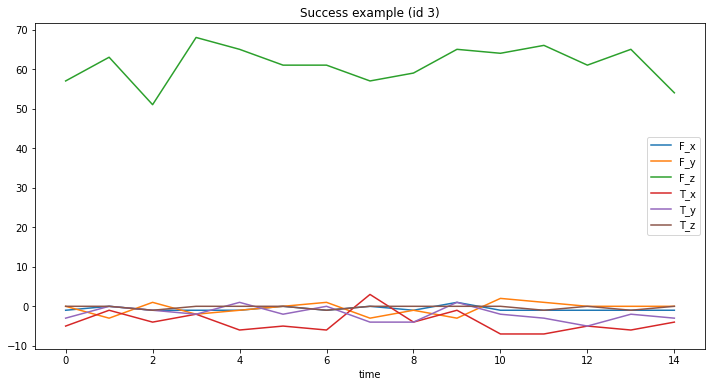

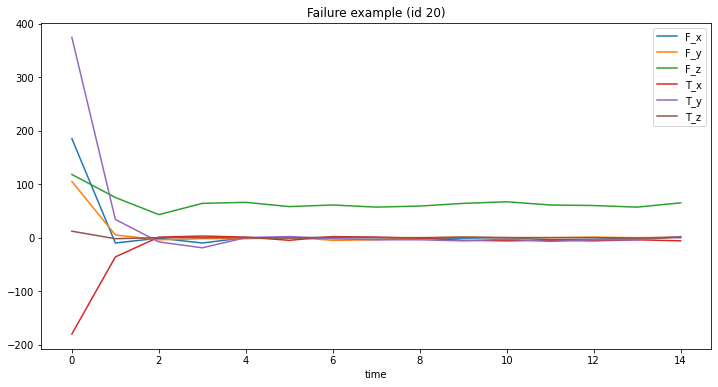

In [ ]:
# 4.0
df[df.id == 3][['time', 'F_x', 'F_y', 'F_z', 'T_x', 'T_y', 'T_z']].plot(x='time', title='Success example (id 3)', figsize=(12, 6));
df[df.id == 20][['time', 'F_x', 'F_y', 'F_z', 'T_x', 'T_y', 'T_z']].plot(x='time', title='Failure example (id 20)', figsize=(12, 6));

## Extract Features
For what all feature engineering is performed on features, see [here](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html)

We can use the data to extract time series features using `tsfresh`.
We want to extract features for each time series, that means for each robot execution (which is our `id`) and for each of the measured sensor values (`F_*` and `T_*`).

You can think of it like this: tsfresh will result in a single row for each `id` and will calculate the features for each columns (we call them "kind") separately.

The `time` column is our sorting column.
For an overview on the data formats of `tsfresh`, please have a look at [the documentation](https://tsfresh.readthedocs.io/en/latest/text/data_formats.html).

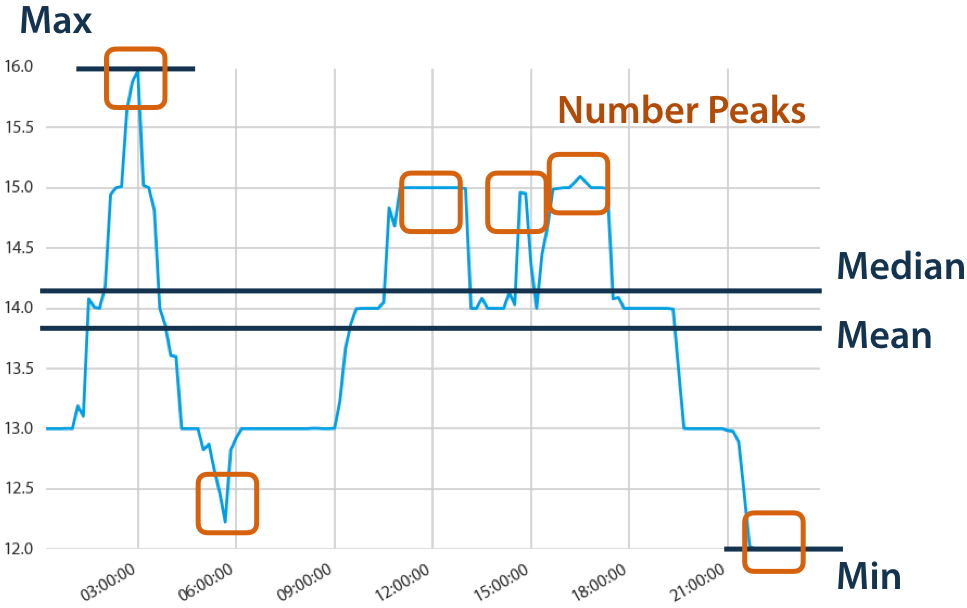

In [ ]:
# 5.0
# We are very explicit here and specify the `default_fc_parameters`. 
# If you remove this argument, the ComprehensiveFCParameters 
# (= all feature calculators) will also be used as default.
# Have a look into the documentation 
# (https://tsfresh.readthedocs.io/en/latest/text/feature_extraction_settings.html)
# or one of the other notebooks to learn more about this.
extraction_settings = ComprehensiveFCParameters()

In [ ]:
# 5.1
X = extract_features(df,
                     column_id='id',
                     column_sort='time',
                     default_fc_parameters=extraction_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute
                     )

Feature Extraction: 100%|██████████| 528/528 [00:24<00:00, 21.24it/s]


`X` now contains for each robot execution (= `id`) a single row, with all the features `tsfresh` calculated based on the measured times series values for this `id`.

In [ ]:
# 5.2
X.head()
print("\n===========\n")
X.shape

,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,-0.038462,-1.0,...,0.974315,1.288185,1.906155,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
2,0.0,1.0,1.0,1.0,-13.0,25.0,1.000000,0.000000,-0.038462,-1.0,...,1.073543,1.494175,2.079442,0.937156,1.234268,1.540306,1.748067,1.831020,0.0,0.571429
3,0.0,0.0,1.0,1.0,-10.0,12.0,0.714286,0.000000,-0.038462,-1.0,...,1.386294,1.732868,2.079442,1.265857,1.704551,2.019815,2.163956,2.197225,0.0,0.571429
4,0.0,1.0,1.0,1.0,-6.0,16.0,1.214286,-0.071429,-0.038462,0.0,...,1.073543,1.494175,2.079442,1.156988,1.907284,2.397895,2.302585,2.197225,0.0,1.000000
5,0.0,0.0,0.0,1.0,-9.0,17.0,0.928571,-0.071429,0.038462,-1.0,...,0.900256,1.320888,2.079442,1.156988,1.863680,2.271869,2.302585,2.197225,0.0,0.857143


<div class="alert alert-info">

Currently, 4674 non-NaN features are calculated. 
This number varies with the version of `tsfresh` and with your data.
    
</div>

## Select Features

Using the hypothesis tests implemented in `tsfresh` (see [here](https://tsfresh.readthedocs.io/en/latest/text/feature_filtering.html) for more information) it is now possible to select only the relevant features out of this large dataset.

`tsfresh` will do a hypothesis test for each of the features to check, if it is relevant for your given target.

In [ ]:
# 6.0
X_filtered = select_features(X, y)

In [ ]:
# 6.1
X_filtered.shape
X_filtered.head()

(88, 682)

,F_x__value_count__value_-1,F_x__abs_energy,F_x__root_mean_square,T_y__absolute_maximum,F_x__mean_n_absolute_max__number_of_maxima_7,F_x__range_count__max_1__min_-1,F_y__abs_energy,F_y__root_mean_square,F_y__mean_n_absolute_max__number_of_maxima_7,T_y__variance,...,"F_y__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)","F_y__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)",T_y__lempel_ziv_complexity__bins_3,T_y__quantile__q_0.1,F_z__time_reversal_asymmetry_statistic__lag_1,F_x__quantile__q_0.2,F_y__quantile__q_0.7,"T_x__change_quantiles__f_agg_""var""__isabs_False__qh_0.2__ql_0.0",T_z__large_standard_deviation__r_0.35000000000000003,T_z__quantile__q_0.9
1,14.0,14.0,0.966092,1.0,1.000000,15.0,13.0,0.930949,1.000000,0.222222,...,-0.310265,-0.751682,0.400000,-1.0,-596.000000,-1.0,-1.0,0.0,0.0,0.0
2,7.0,25.0,1.290994,5.0,1.571429,13.0,76.0,2.250926,3.000000,4.222222,...,-0.202951,0.057818,0.533333,-3.6,-680.384615,-1.0,-1.0,0.0,1.0,0.0
3,11.0,12.0,0.894427,5.0,1.000000,14.0,40.0,1.632993,2.142857,3.128889,...,0.539121,0.912474,0.533333,-4.0,-617.000000,-1.0,0.0,0.0,1.0,0.0
4,5.0,16.0,1.032796,6.0,1.285714,10.0,60.0,2.000000,2.428571,7.128889,...,-2.641390,-0.609735,0.533333,-4.6,3426.307692,-1.0,1.0,0.0,0.0,0.0
5,9.0,17.0,1.064581,5.0,1.285714,13.0,46.0,1.751190,2.285714,4.160000,...,0.591927,0.072771,0.466667,-5.0,-2609.000000,-1.0,0.8,0.0,0.0,0.6


<div class="alert alert-info">

Currently, 669 non-NaN features survive the feature selection given this target.
Again, this number will vary depending on your data, your target and the `tsfresh` version.
    
</div>

## Train and evaluate classifier

Let's train a boosted decision tree on the filtered as well as the full set of extracted features.

In [ ]:
X_full_train, X_full_test, y_train, y_test = train_test_split(X,
                                                              y,
                                                              test_size=.4
                                                              )

In [ ]:
X_filtered_train, X_filtered_test = X_full_train[X_filtered.columns], X_full_test[X_filtered.columns]

In [ ]:
classifier_full = DecisionTreeClassifier()

In [ ]:
classifier_full.fit(X_full_train, y_train)

DecisionTreeClassifier()

In [ ]:
print(classification_report(y_test, classifier_full.predict(X_full_test)))

              precision    recall  f1-score   support

       False       1.00      0.96      0.98        27
        True       0.90      1.00      0.95         9

    accuracy                           0.97        36
   macro avg       0.95      0.98      0.96        36
weighted avg       0.98      0.97      0.97        36



In [ ]:
classifier_filtered = DecisionTreeClassifier()

In [ ]:
classifier_filtered.fit(X_filtered_train, y_train)

DecisionTreeClassifier()

In [ ]:
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))

              precision    recall  f1-score   support

       False       1.00      0.96      0.98        27
        True       0.90      1.00      0.95         9

    accuracy                           0.97        36
   macro avg       0.95      0.98      0.96        36
weighted avg       0.98      0.97      0.97        36



Compared to using all features (`classifier_full`), using only the relevant features (`classifier_filtered`) achieves better classification performance with less data.

<div class="alert alert-info">

Please remember that the hypothesis test in `tsfresh` is a statistical test.
You might get better performance with other feature selection methods (e.g. training a classifier with
all but one feature to find its importance) - but in general the feature selection implemented
in `tsfresh` will give you a very reasonable set of selected features.
    
</div>

## Extraction and Filtering is the same as filtered Extraction

Above, we performed the feature extraction and selection independently. 
If you are only interested in the list of selected features, you can run this in one step:

In [ ]:
X_filtered_2 = extract_relevant_features(df,
                                         y,
                                         column_id='id',
                                         column_sort='time',
                                         default_fc_parameters=extraction_settings
                                         )

Feature Extraction: 100%|██████████| 528/528 [00:26<00:00, 19.65it/s]


In [ ]:
(X_filtered.columns == X_filtered_2.columns).all()

True

## Data formats
For details, refer [here](https://tsfresh.readthedocs.io/en/latest/text/data_formats.html)

There are four important column types that make up those DataFrames. Each will be described with an example from the robot failures dataset (in the example above).

> `column_id`:	This column indicates which entities the time series belong to. Features will be extracted individually for each entity (id). The resulting feature matrix will contain <u>one row per id</u>. Each robot is a different entity, so each of it has a different id.<br>

>`column_sort`:	This column contains values which allow to sort the time series (e.g. time stamps). In general, it is <b>NOT</b> required to have equidistant time steps or the same time scale for the different ids and/or kinds. Some features might make however only sense for equidistant time stamps. If you omit this column, the DataFrame is assumed to be already sorted in ascending order. Each of the robot sensor measurements have a time stamp which is used as the column_sort.<br>

>`column_value`:	This column contains the actual values of the time series. This corresponds to the measured values of different sensors on the robots.<br>

>`column_kind`:	This column indicates the names of the different time series types (e.g. different sensors in an industrial application as in the robot dataset). For each kind of time series the features are calculated individually.<br>


Example1: <br>
Flat Dataframe<br>
Imagine you record the values of time series x and y for different objects A and B for three different times t1, t2 and t3. Your resulting DataFrame may look like this:<br>
<pre>
id 	time 	x 	      y
A 	t1 	x(A, t1) 	y(A, t1)
A 	t2 	x(A, t2) 	y(A, t2)
A 	t3 	x(A, t3) 	y(A, t3)
B 	t1 	x(B, t1) 	y(B, t1)
B 	t2 	x(B, t2) 	y(B, t2)
B 	t3 	x(B, t3) 	y(B, t3)
</pre>`
Now, you want to calculate some features with tsfresh so you would pass:

`column_id="id", column_sort="time", column_kind=None, column_value=None`



Example 2:<br>
 Stacked DataFrame or Long DataFrame<br>
If both column_value and column_kind are set to None, the time series data is assumed to be in a flat DataFrame. This means that each different time series must be saved as its own column.<br>

Imagine you record the values of time series x and y for different objects A and B for three different times t1, t2 and t3. Your resulting DataFrame may look like this:<br>
<pre>
id  time 	  x       	y
A 	t1 	x(A, t1) 	y(A, t1)
A 	t2 	x(A, t2) 	y(A, t2)
A 	t3 	x(A, t3) 	y(A, t3)
B 	t1 	x(B, t1) 	y(B, t1)
B 	t2 	x(B, t2) 	y(B, t2)
B 	t3 	x(B, t3) 	y(B, t3)
</pre>
Now, you want to calculate some features with tsfresh so you would pass:<br>

`column_id="id", column_sort="time", column_kind=None, column_value=None`



## Feature extraction
Pl see [here](https://tsfresh.readthedocs.io/en/latest/text/feature_extraction_settings.html)

For convenience, there are three ways to extract  predefined features:<br>

>`ComprehensiveFCParameters`: Includes all features without parameters and all features with parameters, each with different parameter combinations. This is the default for extract_features if you do not hand in a default_fc_parameters at all.<br>

>`MinimalFCParameters`: Includes only a handful of features and can be used for quick tests. The features which have the “minimal” attribute are used here.<br>


>`EfficientFCParameters`: Mostly the same features as in the tsfresh.feature_extraction.settings.ComprehensiveFCParameters, but without features which are marked with the “high_comp_cost” attribute. This can be used if runtime performance plays a major role.<br>


In [ ]:
################## I am done ##############333